In [1]:
import os
import sys
import numpy as np
import pandas as pd
import importlib
from shutil import rmtree, copy, copytree
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import rcParams
from matplotlib.ticker import ScalarFormatter

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['DejaVu Serif']
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.size'] = 30
rcParams['axes.formatter.use_mathtext'] = True
rcParams['axes.unicode_minus'] = True
rcParams['mathtext.default'] = 'regular'
rcParams['text.usetex'] = False

from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.visualization import (PercentileInterval, LogStretch, PowerStretch, ManualInterval, ZScaleInterval, ImageNormalize)
from astroquery.vizier import Vizier
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u

from casatasks import listobs, split, clearcal, delmod, rmtables, setjy, gaincal, bandpass, applycal, tclean, flagdata, ft, fixvis, phaseshift, casalog, mstransform, exportfits
from casatools import componentlist, msmetadata, imager, ms, table


measures_update ... acquiring the lock ... 
  ... connecting to ftp.astron.nl ...
  ... downloading WSRT_Measures_20250327-160001.ztar from ASTRON server to /data/jfaber/.casa/data ...
  ... measures data updated at /data/jfaber/.casa/data


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import importlib
from shutil import rmtree, copy, copytree
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import rcParams
from matplotlib.ticker import ScalarFormatter

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['DejaVu Serif']
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.size'] = 30
rcParams['axes.formatter.use_mathtext'] = True
rcParams['axes.unicode_minus'] = True
rcParams['mathtext.default'] = 'regular'
rcParams['text.usetex'] = False

from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.visualization import (PercentileInterval, LogStretch, PowerStretch, ManualInterval, ZScaleInterval, ImageNormalize)
from astroquery.vizier import Vizier # type: ignore
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u

from casatasks import listobs, split, clearcal, delmod, rmtables, setjy, gaincal, bandpass, applycal, tclean, flagdata, ft, fixvis, phaseshift, casalog, mstransform, exportfits
from casatools import componentlist, msmetadata, imager, ms, table

# Set path for measurement set, analysis output, and CASA log files
basepath = '/data/jfaber/dsa110-contimg/sandbox/2025-03-18/'
casalog.setlogfile(f'{basepath}/casa_logfile.log')

sys.path.insert(0, '/data/jfaber/dsa110-contimg/pipeline/calib')
from calib_utils import sort_msfiles, gen_fieldnames, reset_msfile, flag_rfi, flag_general, downchan_msfile, apply_bandpass, phase_calib, apply_phase

sys.path.insert(0, '/data/jfaber/dsa110-contimg/pipeline/skymodel')
from skymodel_utils import make_skymodel, image_skymodel # type: ignore

sys.path.insert(0, '/data/jfaber/dsa110-contimg/pipeline/image')
from image_utils import image_tclean # type: ignore

# Define MS files (sorted)
#msfiles_sorted = sort_msfiles(os.path.join(basepath, 'msfiles', 'base'))
# Rerunning for calibrator 3C138, no need to re-do averaging
msfiles_sorted = sort_msfiles(os.path.join(basepath, 'msfiles', 'avg'))

pcalpack_idxs = np.arange(0, 126, 5)
msfiles_pcalpacks = []
for i in pcalpack_idxs:
    if i < 119:
        msfiles_pcalpacks.append(msfiles_sorted[i:i+5])
    else:
        msfiles_pcalpacks.append(msfiles_sorted[i:i+6])


In [8]:
# Define baseband calibration table
bcalfile = '3C138_2025-03-18T01:30:21_f0f23.bcal'
# Define number of sources from NVSS field to include in the sky model
top_n = 50
# Define field range covered within each MS at a time
start_fields = (0,23)

for msfiles_ppack in msfiles_pcalpacks:

    start_msfile = msfiles_ppack[0]
    print(f'Starting MS file: {start_msfile}')
    start_msdate = start_msfile.split('_')[0]
    start_ra_str = f"{start_msfile.split('_')[1][2:5]}p{start_msfile.split('_')[1][6:9]}"
    start_dec_str = f"{start_msfile.split('_')[2][4:6]}p{start_msfile.split('_')[2][7:8]}"
    start_first_field, start_last_field = start_fields
    pcalfile = f'nvss_top200_{start_ra_str}_{start_dec_str}_{start_msdate}_f{start_first_field}f{start_last_field}.pcal' # note top_n is hardcoded here!!!
    print(f'Associated phase calibration table: {pcalfile}')

Starting MS file: 2025-03-18T07:02:34_ra163.7_dec+16.6_sb4.ms
Associated phase calibration table: nvss_top200_163p7_16p6_2025-03-18T07:02:34_f0f23.pcal
Starting MS file: 2025-03-18T07:28:20_ra170.2_dec+16.6_sb4.ms
Associated phase calibration table: nvss_top200_170p2_16p6_2025-03-18T07:28:20_f0f23.pcal
Starting MS file: 2025-03-18T08:00:44_ra178.3_dec+16.6_sb4.ms
Associated phase calibration table: nvss_top200_178p3_16p6_2025-03-18T08:00:44_f0f23.pcal
Starting MS file: 2025-03-18T08:26:30_ra184.8_dec+16.6_sb4.ms
Associated phase calibration table: nvss_top200_184p8_16p6_2025-03-18T08:26:30_f0f23.pcal
Starting MS file: 2025-03-18T08:58:58_ra192.9_dec+16.6_sb4.ms
Associated phase calibration table: nvss_top200_192p9_16p6_2025-03-18T08:58:58_f0f23.pcal
Starting MS file: 2025-03-18T09:24:44_ra199.4_dec+16.6_sb4.ms
Associated phase calibration table: nvss_top200_199p4_16p6_2025-03-18T09:24:44_f0f23.pcal
Starting MS file: 2025-03-18T09:57:08_ra207.5_dec+16.6_sb4.ms
Associated phase calibrati

Set OBSGEO-B to    37.280380 from OBSGEO-[XYZ].
Set OBSGEO-H to     2193.256 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


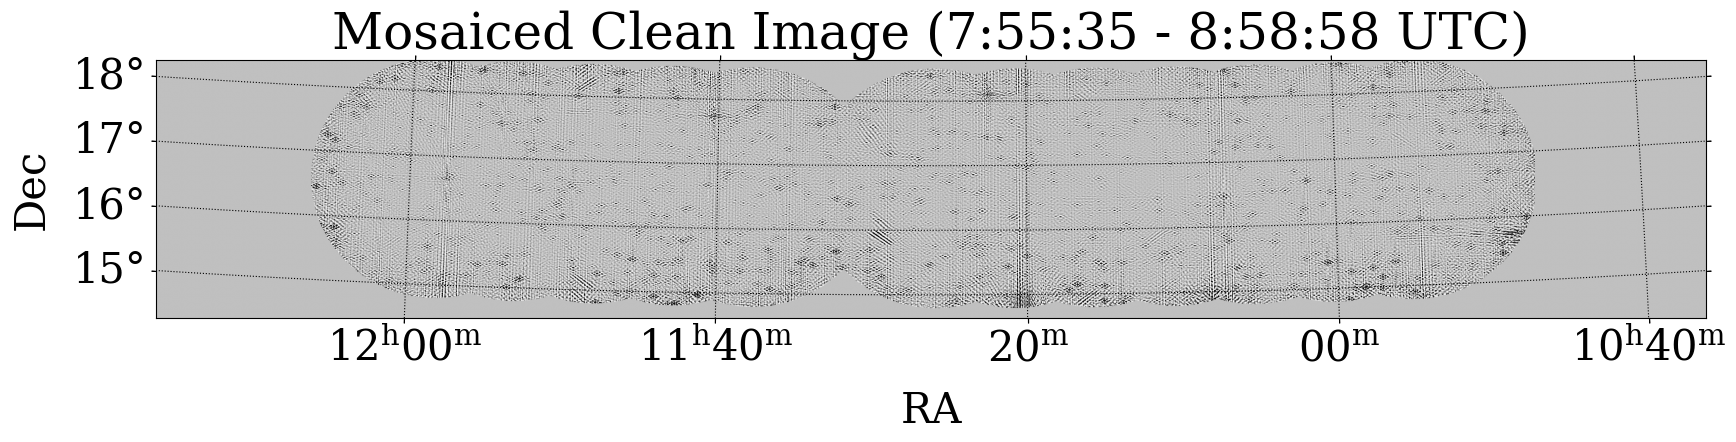

In [ ]:
fits_file = '/data/jfaber/dsa110-contimg/sandbox/2025-03-18_trial1/mosaics/mosaic_2025-03-18T07:02:34_2025-03-18T08:05:53_ra63.7_79.6_dec+16.6.ms_+16.6.ms.linmos.fits'
hdu = fits.open(fits_file)[0]
freq_val = hdu.header['CRVAL3']  # Central frequency (e.g., 1.404882070235e+09 Hz)
stokes_val = hdu.header['CRVAL4']  # Default Stokes parameter (e.g., 1)
wcs = WCS(hdu.header)

slices = (0, 0)  # Adjust this based on your FITS file (e.g., for time or frequency)
wcs_2d = WCS(hdu.header, naxis=2)

# Display the FITS image
fig, ax = plt.subplots(subplot_kw={'projection': wcs_2d}, figsize = (20, 20))
#norm = ImageNormalize(hdu.data[0, 0, :, :], interval=PercentileInterval(99), stretch=LogStretch())
norm = ImageNormalize(hdu.data[0, 0, :, :], interval=ZScaleInterval(), stretch=PowerStretch(a=4))
ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', norm=norm, origin='lower')
#ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', origin='lower', vmax = 0.1*np.max(hdu.data[0, 0, :, :])) #norm=norm, origin='lower', vmax = 0.1*np.max(hdu.data[0, 0, :, :]))

ax.set_xlabel('RA')
ax.set_ylabel('Dec')

# Show the plot
plt.title('Mosaiced Clean Image (7:55:35 - 8:58:58 UTC)')
plt.grid(color='k', ls='dotted')

In [1]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
print(x[:12])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [2]:
basepath = '/data/jfaber/dsa110-contimg/sandbox/2025-03-18_trial1/'
msfile = '2025-03-18T19:00:04_ra343.6_dec+16.4_sb4.ms'
msfile_bpcorr = '2025-03-18T19:00:04_ra343.6_dec+16.4_sb4_bpcorr.ms'

In [3]:
sys.path.insert(0, '/data/jfaber/dsa110-contimg/pipeline/calib')
from calib_utils import sort_msfiles, reset_msfile, flag_rfi, flag_general, downchan_msfile, apply_bandpass, phase_calib, apply_phase

In [4]:
msfiles_sorted = sort_msfiles(os.path.join(basepath, 'msfiles', 'base'))

In [ ]:
#msfiles_sorted_flip = np.flip(msfiles_sorted)
msfiles_thirty = []
for i in range(0, 120, 5):
    msfiles_thirty.append(msfiles_sorted[i])

#msfiles_lastthirty = msfiles_sorted_flip[0:7]
print(f'MS Files covering the last 30 minutes: {msfiles_thirty}')

MS Files covering the last 30 minutes: ['2025-03-18T07:02:34_ra163.7_dec+16.6.ms', '2025-03-18T07:28:20_ra170.2_dec+16.6.ms', '2025-03-18T08:00:44_ra178.3_dec+16.6.ms', '2025-03-18T08:26:30_ra184.8_dec+16.6.ms', '2025-03-18T08:58:58_ra192.9_dec+16.6.ms', '2025-03-18T09:24:44_ra199.4_dec+16.6.ms', '2025-03-18T09:57:08_ra207.5_dec+16.6.ms', '2025-03-18T10:22:54_ra214.0_dec+16.6.ms', '2025-03-18T10:53:25_ra222.1_dec+16.6.ms', '2025-03-18T11:21:06_ra228.6_dec+16.6.ms', '2025-03-18T11:46:52_ra235.1_dec+16.6.ms', '2025-03-18T12:19:18_ra243.2_dec+16.6.ms', '2025-03-18T12:45:04_ra249.7_dec+16.6.ms', '2025-03-18T13:17:31_ra257.8_dec+16.5.ms', '2025-03-18T13:43:17_ra264.3_dec+16.5.ms', '2025-03-18T14:15:44_ra272.4_dec+16.5.ms', '2025-03-18T14:41:30_ra278.8_dec+16.5.ms', '2025-03-18T15:13:55_ra287.0_dec+16.5.ms', '2025-03-18T15:39:41_ra293.4_dec+16.5.ms', '2025-03-18T16:10:13_ra301.6_dec+16.4.ms', '2025-03-18T16:37:55_ra308.0_dec+16.4.ms', '2025-03-18T17:03:41_ra314.5_dec+16.4.ms', '2025-03-18T17

In [21]:
ppack_idxs = np.arange(0, 126, 5)[:-1]
msfiles_ppacks = []
for i in ppack_idxs:
    if i < 119:
        msfiles_ppacks.append(msfiles_sorted[i:i+5])
    else:
        msfiles_ppacks.append(msfiles_sorted[i:i+6])

print(len(msfiles_ppacks))
print(msfiles_ppacks[24])

25
['2025-03-18T18:34:18_ra337.2_dec+16.4.ms', '2025-03-18T18:39:27_ra338.5_dec+16.4.ms', '2025-03-18T18:44:37_ra339.8_dec+16.4.ms', '2025-03-18T18:49:46_ra341.1_dec+16.4.ms', '2025-03-18T18:54:55_ra342.4_dec+16.4.ms', '2025-03-18T19:00:04_ra343.6_dec+16.4.ms']


In [ ]:
#'2025-03-18T19:00:04_ra343.6_dec+16.4.ms'
#msfile = '2025-03-18T18:54:55_ra342.4_dec+16.4.ms'
#msfiles_sorted = sort_msfiles(os.path.join(basepath, 'msfiles', 'base'))
#msfiles_sorted_flip = np.flip(msfiles_sorted)
#msfiles_lastthirty = msfiles_sorted_flip[1:7]
#print(f'MS Files covering the last 30 minutes: {msfiles_lastthirty}')
#msfiles_sorted_flip = np.flip(msfiles_sorted)
#msfiles_everythirty = []
#for i in range(0, 120, 5):
#    msfiles_everythirty.append(msfiles_sorted[i])

Primary Beam FWHM (2.693 degrees):
  RA:  262.881633 to 265.574798
  Dec: 15.177012 to 17.870178


Querying VIII/65/nvss/ ...


Found 438 sources in the field!


Querying J/other/A+A/598/A78/table3 ...


No sources found in the TGSS ADR1 catalog.


File 'nvss_top200_264p3_16p5.cl' already exists. Skipping component creation.


NVSS Catalog:
     NVSS       RAJ2000     DEJ2000   e_RAJ2000 ... l_MinAxis MinAxis f_resFlux
                                          s     ...            arcsec          
------------- ----------- ----------- --------- ... --------- ------- ---------
173119+164435 17 31 19.90 +16 44 35.1      0.21 ...         <    34.1          
173119+163352 17 31 19.94 +16 33 52.5      0.05 ...         <    16.6          
173120+170935 17 31 20.95 +17 09 35.2      0.67 ...         <    57.0          
173121+160727 17 31 21.09 +16 07 27.4      0.05 ...         <    18.4          
173123+174159 17 31 23.48 +17 41 59.9      0.25 ...         <    44.5          
173123+175135 17 

2025-03-26 15:26:04	WARN	imager::setdata()	Ignoring that ms/data/jfaber/dsa110-contimg/sandbox/2025-03-18_trial1/msfiles/avg/2025-03-18T13:43:17_ra264.3_dec+16.5_sb4.msspecified here
2025-03-26 15:26:04	WARN	imager::setdata()	Imager was constructed with an ms 
2025-03-26 15:26:04	WARN	imager::setdata()	if multi-ms are to be used please construct imager without parameters and use setdata to specify the ms's and selection
Set OBSGEO-B to    37.280380 from OBSGEO-[XYZ].
Set OBSGEO-H to     2193.256 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]




Sky Model has 200 sources...


Sky model figure saved as nvss_top200_264p3_16p5_image.pdf




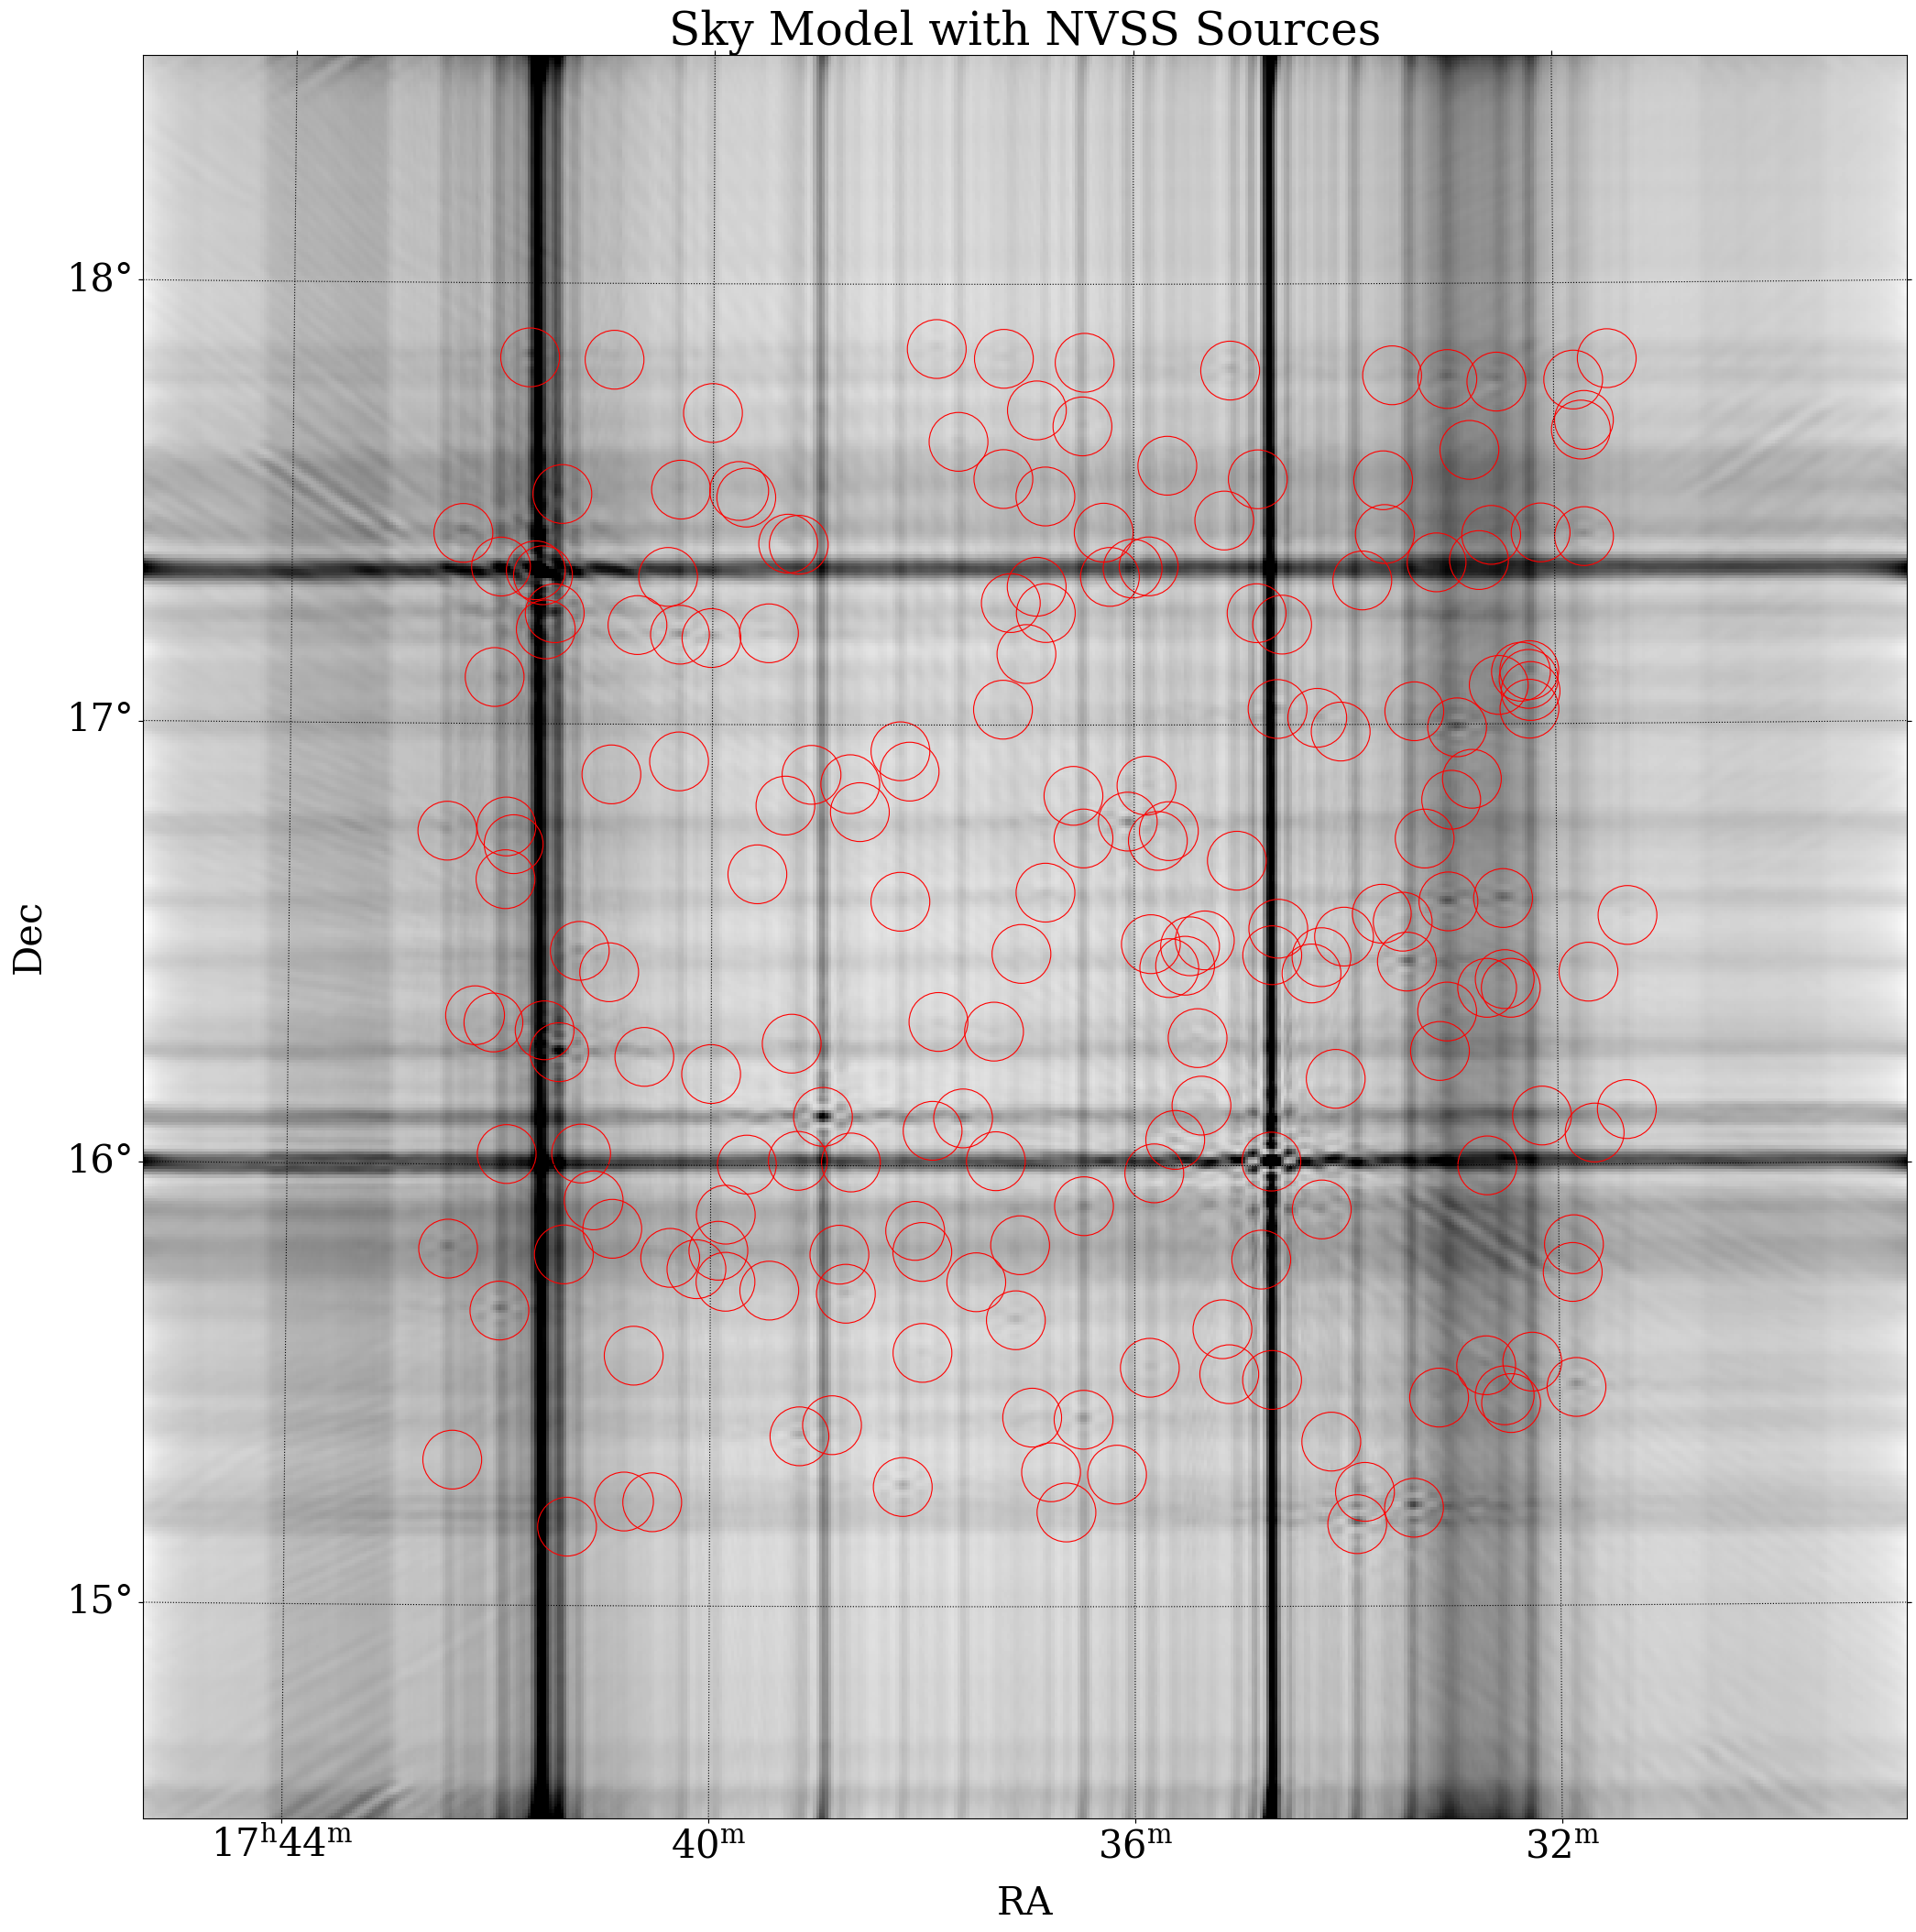

In [3]:
import sys
sys.path.insert(0, '/data/jfaber/dsa110-contimg/pipeline/skymodel')
from skymodel_utils import make_skymodel, image_skymodel # type: ignore

basepath = '/data/jfaber/dsa110-contimg/sandbox/2025-03-18_trial1/'
msfile_avg = '2025-03-18T13:43:17_ra264.3_dec+16.5_sb4.ms'

# Make skymodel with 200 brightest NVSS sources 
nvss_catalog, clfile = make_skymodel(msfile_avg, basepath, sourcename=None, cfieldid=11, top_n=200, pbfrac=0.5)

# Image skymodel
phasecenter, nvss_coords = image_skymodel(msfile_avg, basepath, nvss_catalog, clfile=clfile, cfieldid=11, phasecenter=None, make_image=True)

In [4]:
xs = []
ys = []
for xi, yi in nvss_coords:
    print(xi, yi)

383.3077837659735 222.9661133950891
133.08699031029195 424.14100249245024
135.54036175542015 422.4603819292678
230.7701115596376 238.1786877400318
141.0314501299178 260.1855126268626
431.8212551175468 105.1936976081511
412.5085496657926 99.59753110548431
139.52745166439496 409.53471311305725
334.45654477083156 338.64099519930903
429.3966866250473 291.01367667878225
446.48170392628157 370.7244220845772
487.0853875512836 146.29245217503217
319.41385983062986 135.12885793816628
182.12660612311308 402.2380543779658
278.43305232488734 237.6541644861667
471.0267225083293 390.1837907499778
443.5288425861618 311.4888119970904
471.47049724351984 383.069983980841
120.71664868425955 172.28196423834999
222.77357590945593 129.49249851820244
385.411708570322 376.9583336761621
136.0935899516833 267.62971236342196
350.59687340567984 230.3279508932119
257.91127744322824 112.23260560035854
121.25556248926293 425.4201422970085
103.26651228095747 193.3474029442409
462.1114320721497 312.6327395160368
148.0

In [14]:
print(xs)

[]


In [1]:
from casaconfig import config, get_config

In [2]:
get_config()

['agg = False',
 "cachedir = '/home/jfaber/.casa'",
 'casaconfig_verbose = 1',
 "colors = 'Neutral'",
 'data_auto_update = True',
 "datapath = ['/data/jfaber/.casa/data']",
 'iplog = False',
 "iplogfile = '/data/jfaber/dsa110-contimg/ipython_casa_logfile.log'",
 'log2term = False',
 "logfile = '/data/jfaber/dsa110-contimg/casa_logfile.log'",
 'measures_auto_update = True',
 "measurespath = '/data/jfaber/.casa/data'",
 'nogui = False',
 'nologfile = False',
 'nologger = False',
 'pipeline = False',
 "startupfile = '/home/jfaber/.casa/startup.py'",
 'user_site = False']

In [3]:
# Generate strings for filenames
top_n = 200
pbfrac=0.25

# Open the measurement set
msmd = msmetadata()
msmd.open(os.path.join(basepath, 'msfiles', 'avg', msfile))

# Get the total number of fields
num_fields = msmd.nfields()

# Retrieve phase centers for all fields
phase_centers = []
for field_id in range(num_fields):
    pc = msmd.phasecenter(field_id)
    ra = pc['m0']['value']  # RA in radians
    dec = pc['m1']['value']  # Dec in radians
    phase_centers.append((ra, dec))

# Convert to degrees for easier interpretation
rad2deg = lambda x: ((x * 180.0 / np.pi) + 360) % 360  
phase_centers_deg = [(rad2deg(ra), rad2deg(dec)) for ra, dec in phase_centers]
#phase_centers_deg = (rad2deg(ra), rad2deg(dec))

# Calculate the geometric mean center (central coordinate)
center_ra = np.mean([coord[0] for coord in phase_centers_deg])
center_dec = np.mean([coord[1] for coord in phase_centers_deg])

print(f"Total fields: {num_fields}")
print(f"Geometric center: RA = {center_ra:.6f} deg, Dec = {center_dec:.6f} deg")
print('\n')

# Close the msmd tool
msmd.done()

ra_str = f"{msfile.split('_')[1][2:5]}p{msfile.split('_')[1][6:9]}"
dec_str = f"{msfile.split('_')[2][4:6]}p{msfile.split('_')[2][7:8]}"
clfile = f'nvss_top{top_n}_{ra_str}_{dec_str}.cl'
cllabel = clfile.split('.')[0]

# Add primary beam size (optional)
# Assume observing frequency = 1.4 GHz and dish diameter = 25 m (VLA example)
frequency_hz = 1.4e9  # Hz
dish_diameter_m = 4.65  # meters
primary_beam_fwhm_deg = (1.02 * (3e8 / frequency_hz) / dish_diameter_m) * (180 / np.pi)

# Adjust RA and Dec bounds by primary beam size
min_ra_adjusted = center_ra - pbfrac*primary_beam_fwhm_deg
max_ra_adjusted = center_ra + pbfrac*primary_beam_fwhm_deg
min_dec_adjusted = center_dec - pbfrac*primary_beam_fwhm_deg
max_dec_adjusted = center_dec + pbfrac*primary_beam_fwhm_deg

print(f"Primary Beam FWHM ({primary_beam_fwhm_deg:.3f} degrees):")
print(f"  RA:  {min_ra_adjusted:.6f} to {max_ra_adjusted:.6f}")
print(f"  Dec: {min_dec_adjusted:.6f} to {max_dec_adjusted:.6f}")
print('\n')

ra_deg = center_ra
dec_deg = center_dec

#search_radius =  60 # arcminutes
search_width = max_ra_adjusted - min_ra_adjusted # degrees
search_height = max_dec_adjusted - min_dec_adjusted # degrees
nvss_flux_col = "S1.4"  # NVSS flux column
nvss_cat_code = "VIII/65/nvss/"  # NVSS catalog
tgss_flux_col = "Peak_flux"  # TGSS flux column (150 MHz)
tgss_cat_code = "J/other/A+A/598/A78/table3"  # TGSS ADR1 catalog

# Function to calculate spectral index
def calculate_spectral_index(flux_nvss, freq_nvss, flux_tgss, freq_tgss):
    return np.log(flux_nvss / flux_tgss) / np.log(freq_nvss / freq_tgss)

# Query the NVSS catalog
print(f"Querying {nvss_cat_code} ...")
print('\n')
target_coord = SkyCoord(ra_deg, dec_deg, unit='deg')
Vizier.ROW_LIMIT = -1  # no row limit
Vizier.columns = ["*"]  # retrieve all columns

while True:
    try:
        nvss_result = Vizier.query_region(
            target_coord,
            #adius=f"{search_radius}m",
            width=f"{search_width}d",
            height=f"{search_height}d",
            catalog=nvss_cat_code,
            frame='icrs'
        )
        break
    except Exception as e:
        print(f"An error occurred: {e}")


nvss_catalog = nvss_result[0]

Total fields: 24
Geometric center: RA = 343.643485 deg, Dec = 16.371897 deg


Primary Beam FWHM (2.693 degrees):
  RA:  342.970194 to 344.316777
  Dec: 15.698606 to 17.045189


Querying VIII/65/nvss/ ...




In [4]:
msfile_bcorr = '2025-03-18T19:00:04_ra343.6_dec+16.4_sb4_bcorr.ms'

sys.path.insert(0, '/data/jfaber/dsa110-contimg/pipeline/calib')
from calib_utils import gen_fieldnames

pcalfile = 'nvss_top200_343p6_16p4_2025-03-18T19:00:04_f0f23.pcal'

fieldnames, first_field, last_field = gen_fieldnames(msfile, basepath, fields=(0,23))

applycal(vis=os.path.join(basepath, 'msfiles', 'avg', msfile_bcorr),
         field=fieldnames,
         gaintable=os.path.join(basepath, 'pcalfiles', pcalfile))

Specified field range goes from 0 to 23




In [5]:
sys.path.insert(0, '/data/jfaber/dsa110-contimg/pipeline/skymodel')
from skymodel_utils import make_skymodel, image_skymodel # type: ignore

phasecenter = image_skymodel(msfile_bcorr, basepath, nvss_catalog, clfile=clfile, cfieldid=11, phasecenter=None, make_image=False)

Image Parameters
----------------
nx, ny: (600, 600)
cellx, celly: ('24arcsec', '24arcsec')
mode: mfs


Phase Center: J2000 22h54m34.436508215819686s 16d22m18.830837060575618s


MS Selected: /data/jfaber/dsa110-contimg/sandbox/2025-03-18_trial1/msfiles/avg/2025-03-18T19:00:04_ra343.6_dec+16.4_sb4_bcorr.ms




2025-03-25 13:09:01	WARN	imager::setdata()	Ignoring that ms/data/jfaber/dsa110-contimg/sandbox/2025-03-18_trial1/msfiles/avg/2025-03-18T19:00:04_ra343.6_dec+16.4_sb4_bcorr.msspecified here
2025-03-25 13:09:01	WARN	imager::setdata()	Imager was constructed with an ms 
2025-03-25 13:09:01	WARN	imager::setdata()	if multi-ms are to be used please construct imager without parameters and use setdata to specify the ms's and selection




Sky Model has 138 sources...




Set OBSGEO-B to    37.280380 from OBSGEO-[XYZ].
Set OBSGEO-H to     2193.256 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [ ]:
fieldnames, first_field, last_field = gen_fieldnames(msfile_bcorr, basepath, fields=(0,23))

Specified field range goes from 0 to 23




In [ ]:
sys.path.insert(0, '/data/jfaber/dsa110-contimg/pipeline/image')
import image_utils
importlib.reload(image_utils)
from image_utils import image_tclean

image_tclean(msfile_bcorr, basepath, phasecenter)

Specified field range goes from 0 to 23





0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%


In [20]:
image_tclean?

Signature:
image_tclean(
    basepath,
    msfile,
    phasecenter,
    imsize=(4800, 4800),
    cell_res='3arcsec',
    weighttype='briggs',
    niter=10000,
    weight=0.5,
    uvrange='>1klambda',
    imagetype='clean',
    save_fits=True,
)
Docstring: <no docstring>
File:      /data/jfaber/dsa110-contimg/pipeline/image/image_utils.py
Type:      function

In [16]:
msfile = '/data/jfaber/dsa110-contimg/sandbox/2025-03-18_trial1/msfiles/avg/2025-03-18T19:00:04_ra343.6_dec+16.4_sb4_bcorr.ms'
imsize_x, imsize_y = 4800, 4800
cell_res = '3arcsec'
weighttype = 'natural'
niter = 10000
weight = 0.5
uvrange = '1klambda'
imagetype = 'clean'
imageparams = f'{imagetype}_{weighttype}{weight}_uv{uvrange}_{imsize_x}x{cell_res[:4]}_nitr{niter}'
imagename = f'{msfile.split(".ms")[0]}_f{0}f{23}_{imageparams}'
tclean(vis=os.path.join(basepath, msfile),
    field=fieldnames,            
    imagename=os.path.join(basepath, imagename),
    specmode='mfs',
    deconvolver='hogbom',
    gridder='wproject',
    wprojplanes=-1,  # auto (if using wproject)
    niter=niter,             
    threshold='0.005Jy',
    interactive=False,
    imsize=[imsize_x, imsize_y],
    cell=[cell_res], 
    weighting=weighttype,
    robust=weight,
    pblimit=0.25,
    psfcutoff=0.5,
    uvrange='>'+uvrange,
    phasecenter=phasecenter,
    #startmodel=startmodel_nvss
    )


0%....10....20....30....40....50....60....70....80....90....100%


KeyboardInterrupt: 

In [2]:

# Allow for all rows in the result
Vizier.ROW_LIMIT = -1
target_coord = SkyCoord(156, +71, unit='deg', frame='icrs')
# Query the calibrator by name from the VLA calibrator catalog (e.g., "VII/233")
nvss_result = Vizier.query_region(
        target_coord,
        #radius=f"{search_radius}m",
        width="3d",
        height="3d",
        catalog="VIII/65/nvss",
        frame='icrs'
    )

In [5]:
result = Vizier.query_object("3C 454.3", catalog="VII/233")
catalog = result[0]
result = Vizier.query_object("3C454.3", catalog="VIII/65/nvss")
catalog = result[0]

In [8]:
nvss_flux_col = "S1.4"  # NVSS flux column
catalog = catalog[~catalog[nvss_flux_col].mask]  # Remove masked (NaN) values
catalog_top_sources = catalog

In [9]:
print(catalog_top_sources)

     NVSS       RAJ2000     DEJ2000   e_RAJ2000 ... l_MinAxis MinAxis f_resFlux
                                          s     ...            arcsec          
------------- ----------- ----------- --------- ... --------- ------- ---------
225357+160853 22 53 57.70 +16 08 53.4      0.03 ...         <    13.9        P*


In [10]:
nvss_coords = SkyCoord(ra=catalog_top_sources['RAJ2000'], dec=catalog_top_sources['DEJ2000'], frame='icrs', unit=(u.hourangle, u.deg))

In [12]:
print(nvss_coords.ra.deg[0])

343.49041666666665


In [17]:
table = result[0]
table.pprint(max_lines=-1)

     NVSS       RAJ2000     DEJ2000   e_RAJ2000 ... l_MinAxis MinAxis f_resFlux
                                          s     ...            arcsec          
------------- ----------- ----------- --------- ... --------- ------- ---------
225357+160853 22 53 57.70 +16 08 53.4      0.03 ...         <    13.9        P*


In [19]:
table.pprint(max_lines=-1, max_width=-1)

     NVSS       RAJ2000     DEJ2000   e_RAJ2000 e_DEJ2000   S1.4    e_S1.4 l_MajAxis MajAxis l_MinAxis MinAxis f_resFlux
                                          s       arcsec    mJy      mJy              arcsec            arcsec          
------------- ----------- ----------- --------- --------- -------- ------- --------- ------- --------- ------- ---------
225357+160853 22 53 57.70 +16 08 53.4      0.03       0.6  12656.8   379.7         <    14.4         <    13.9        P*


In [5]:

if result:
    table = result[0]
    # Inspect the table to see available columns (e.g., RAJ2000, DEJ2000)
    print(table)
else:
    print("Calibrator J2253+1608 not found in the catalog.")

Calibrator J2253+1608 not found in the catalog.
